In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
base_shape_size = 8192
ws = 255
ol = 128
input_shape = (128, 64, 2)

In [3]:
from utils import calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from sound import Sound
from data_generators import NoisyTargetGenerator
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, hilbert
from scipy.fft import fft, fftfreq

In [4]:
from IPython.display import Audio
from IPython import display
import librosa

In [5]:
sound_base_train = Sound('/tf/Dados/Vozes/train/', '/tf/Dados/Ruido/train/', base_shape_size)
sound_base_val = Sound('/tf/Dados/Vozes/val/', '/tf/Dados/Ruido/val/', base_shape_size)

Loading Speech Files: 100%|██████████| 5725/5725 [01:53<00:00, 50.24it/s] 
/tf/utils/sound.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:74: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]
Loading Noise Files: 100%|██████████| 1627/1627 [00:27<00:00, 59.19it/s] 


In [6]:
data_generator_train = NoisyTargetGenerator(sound_base_train.clean_sounds, sound_base_train.noise_sounds)
data_generator_val = NoisyTargetGenerator(sound_base_val.clean_sounds, sound_base_val.noise_sounds)

In [7]:
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=8))
x_test, y_test = validation_batch

x_test = x_test[0, ...]
y_test = y_test[0, ...]

x_test = x_test[np.newaxis, ...]
y_test = y_test[np.newaxis, ...]

In [8]:
A = y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_noisy = x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_noisy = (x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

In [9]:
i = 1000
step = 600

In [10]:
speech = reconstruct_signal_from_stft(A, phi)[i:i+step]
speech = speech / np.max(np.abs(speech))

speech_noisy = reconstruct_signal_from_stft(A_noisy, phi_noisy)[i:i+step]
speech_noisy = speech_noisy / np.max(np.abs(speech_noisy))

In [11]:
full_speech = reconstruct_signal_from_stft(A, phi)
full_speech = full_speech / np.max(np.abs(full_speech))

In [12]:
Audio(data=full_speech, rate=8000)

In [13]:
Audio(data=speech, rate=8000)

In [14]:
Audio(data=speech_noisy, rate=8000)

/usr/local/lib/python3.8/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 600, using nperseg = 600
  warnings.warn('nperseg = {0:d} is greater than input length '


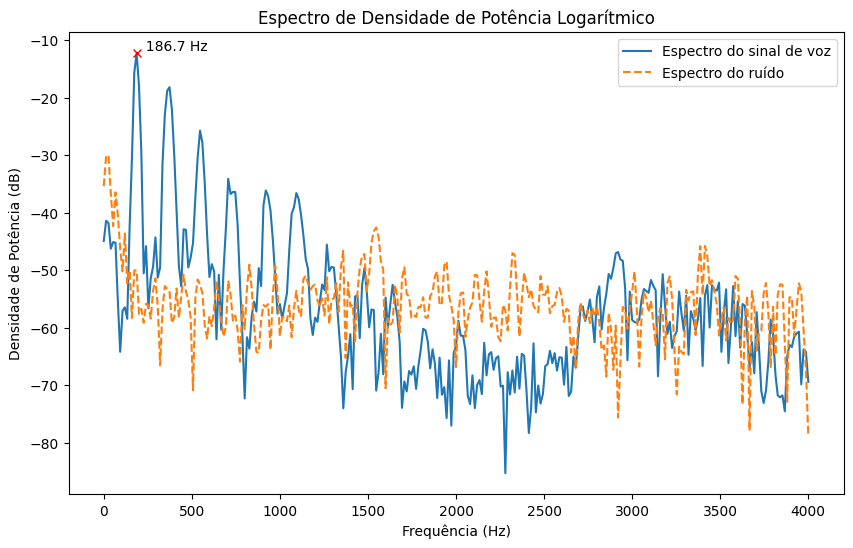

In [15]:
frequencies, power_density = welch(speech, fs=8000, window='hann', nperseg=1024, scaling='spectrum')
frequencies_noisy, power_density_noisy = welch(speech_noisy-speech, fs=8000, window='hann', nperseg=1024, scaling='spectrum')

# Convertendo para escala logarítmica
power_density_db = 10 * np.log10(power_density + np.finfo(float).eps)
power_density_db_noisy = 10 * np.log10(power_density_noisy + np.finfo(float).eps)

# Plotando o espectro de densidade de potência
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_density_db, label='Espectro do sinal de voz')
plt.plot(frequencies_noisy, power_density_db_noisy, label='Espectro do ruído', linestyle='--')
plt.title('Espectro de Densidade de Potência Logarítmico')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade de Potência (dB)')
plt.legend()

# Identificando e marcando as formantes
# Uma abordagem simples é procurar os picos no PSD. Este é um exemplo básico e pode precisar de ajustes.
from scipy.signal import find_peaks
peaks, _ = find_peaks(power_density_db, height=-20, distance=50) # ajuste os parâmetros conforme necessário

for peak in peaks:
    plt.plot(frequencies[peak], power_density_db[peak], 'rx') # marcando com 'x' vermelho
    plt.text(frequencies[peak], power_density_db[peak], f'  {frequencies[peak]:.1f} Hz', verticalalignment='bottom')

plt.show()

[ 1.         -1.4995917  -0.13202253  0.8816339   0.6141386  -1.439657
  0.37191632  0.5347818  -0.13373944 -0.5020793   0.54374725 -0.22430821]


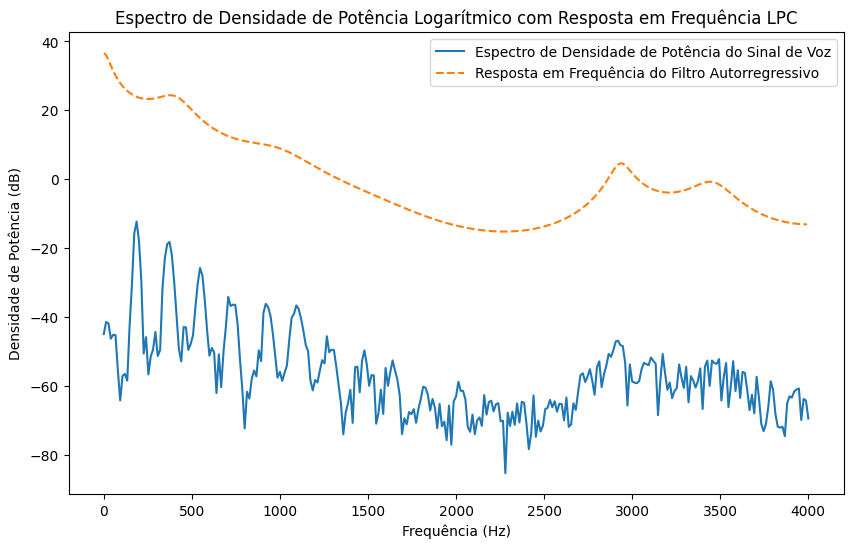

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, freqz
import librosa

# Supondo que 'speech' é o seu sinal de voz
# Parâmetros iniciais
fs = 8000

# Cálculo do Espectro de Densidade de Potência
frequencies, power_density = welch(speech, fs=fs, window='hann', nperseg=1024, scaling='spectrum')

# Convertendo para escala logarítmica
power_density_db = 10 * np.log10(power_density + np.finfo(float).eps)

# Cálculo dos coeficientes LPC
lpc_order = 11  # Ou qualquer outra ordem que você deseje usar
lpc_coeffs = librosa.lpc(speech, order=lpc_order)
print(lpc_coeffs)
# Calculando a resposta em frequência do filtro LPC
w, h = freqz([1], lpc_coeffs, worN=512)
# Convertendo a frequência de rad/sample para Hz e a magnitude para dB
frequencies_lpc = w * fs / (2 * np.pi)
magnitude_lpc = 20 * np.log10(abs(h))

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_density_db, label='Espectro de Densidade de Potência do Sinal de Voz')
plt.plot(frequencies_lpc, magnitude_lpc, label='Resposta em Frequência do Filtro Autorregressivo', linestyle='--')
plt.title('Espectro de Densidade de Potência Logarítmico com Resposta em Frequência LPC')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade de Potência (dB)')
plt.legend()
plt.show()

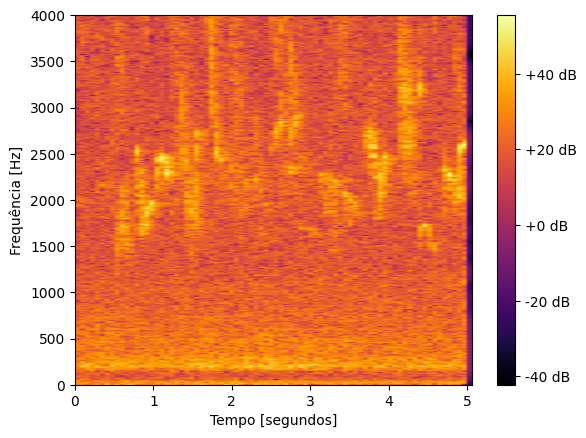

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft

# Substitua 'caminho_para_seu_arquivo.wav' pelo caminho real do seu arquivo WAV
caminho_do_arquivo = '/tf/Dados/nao_estacionario.wav'

# Ler o arquivo WAV
taxa_de_amostragem, dados = wavfile.read(caminho_do_arquivo)

# Assegurar que os dados estão em formato float para a transformação
dados = dados.astype(float)

# Calcular a STFT
f, t, Zxx = stft(dados, taxa_de_amostragem, nperseg=1024)

magnitude_squared_db = 10 * np.log10(np.abs(Zxx)**2)

# Plotar a STFT
plt.imshow(magnitude_squared_db, aspect='auto', origin='lower', cmap='inferno', extent=[t.min(), t.max(), f.min(), f.max()])
# plt.title('STFT Magnitude')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [segundos]')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plotar a STFT com o estilo especificado
# plt.imshow(magnitude_squared_db, aspect='auto', cmap='inferno', extent=[t.min(), t.max(), f.min(), f.max()])
# plt.title('STFT Magnitude')
# plt.colorbar(format='%+2.0f dB')
# plt.axis('off')  # Remove os eixos
# plt.show()

NameError: name 'signal' is not defined

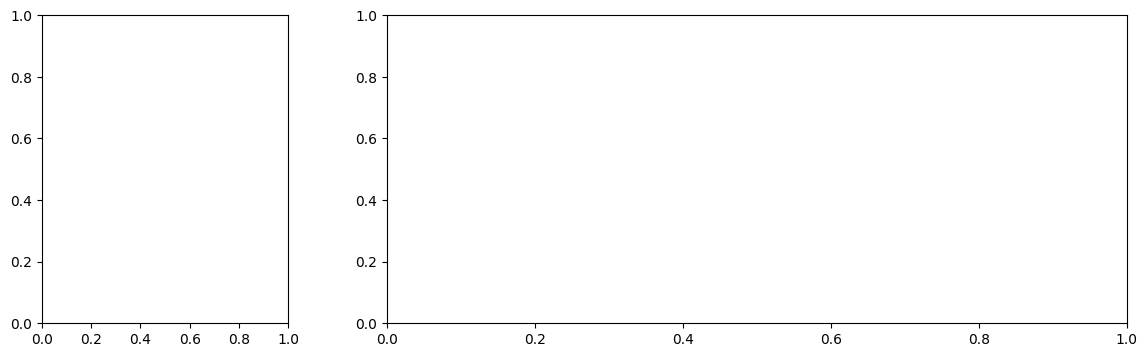

In [18]:
# Criando a figura e os subplots com proporção de 3:1 para o sinal e histograma
fig, axs = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'width_ratios': [1, 3]})

# Plotar o sinal
axs[1].plot(t, signal)
axs[1].set_title('Ruído Gaussiano Branco')
axs[1].set_xlabel('Tempo (segundos)')
axs[1].set_ylabel('Magnitude')

# Plotar o histograma com as linhas ajustadas
axs[0].barh(bin_centers, hist, height=(bins[1] - bins[0]), color='green')
# Ajustando as linhas para corresponder à orientação horizontal do histograma
axs[0].axhline(y=mu, label='μ', color='red', linestyle='dashed', linewidth=2)
axs[0].axhline(y=mu+sigma, label='+Sigma', color='blue', linestyle='dashed', linewidth=2)
axs[0].axhline(y=mu-sigma, label='- Sigma', color='blue', linestyle='dashed', linewidth=2)
axs[0].set_xlabel('Probabilidade')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].set_title('Histograma do ruído')

# Ajustar o layout para evitar sobreposições
fig.tight_layout()

# Mostrar o gráfico
plt.show()


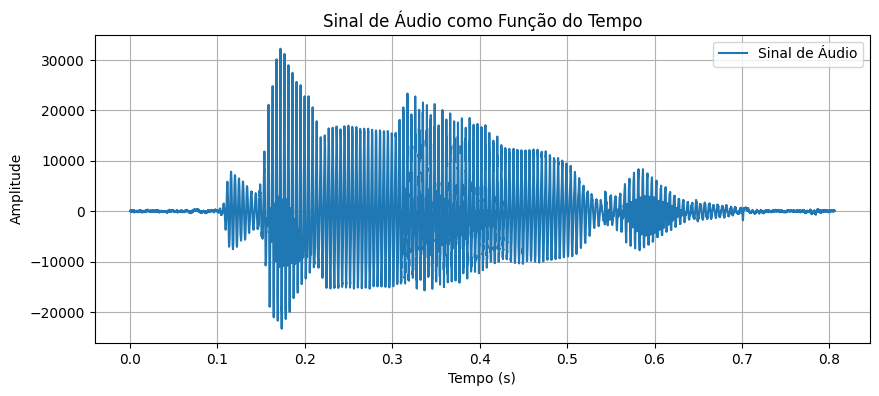

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Caminho do arquivo WAV
file_path = '/tf/Dados/26.wav'

# Lendo o arquivo WAV
sampling_rate, data = wavfile.read(file_path)

# Se o arquivo WAV for estéreo, você pode querer usar apenas um canal
if len(data.shape) > 1:
    data = data[:, 0]  # Usando apenas o primeiro canal

# Criando o vetor de tempo t, que tem o mesmo número de pontos que o sinal e representa o tempo em segundos
t = np.arange(len(data)) / sampling_rate

# Criando o plot
plt.figure(figsize=(10, 4))  # Configura o tamanho da figura
plt.plot(t[:8000], data[:8000], label='Sinal de Áudio')  # Plota o sinal de áudio
plt.xlabel('Tempo (s)')  # Rótulo do eixo x
plt.ylabel('Amplitude')  # Rótulo do eixo y
plt.title('Sinal de Áudio como Função do Tempo')  # Título do gráfico
plt.legend()  # Adiciona a legenda
plt.grid(True)  # Adiciona grade ao gráfico para melhor visualização
plt.show()  # Exibe o gráfico


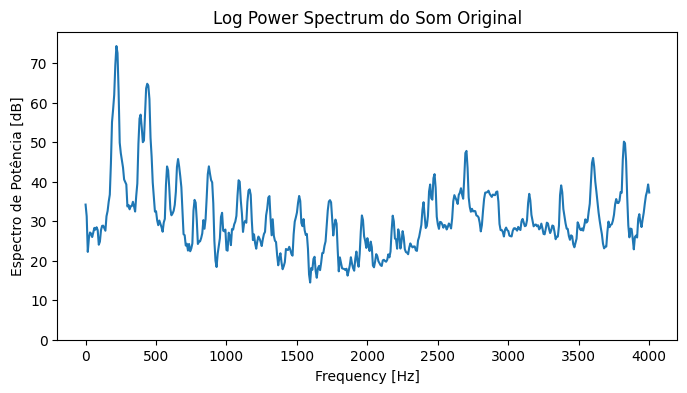

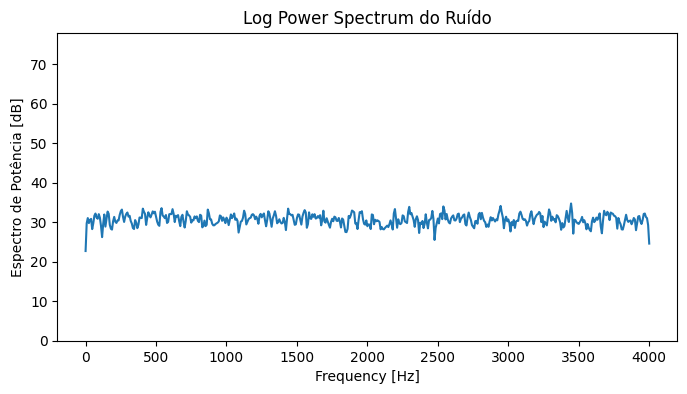

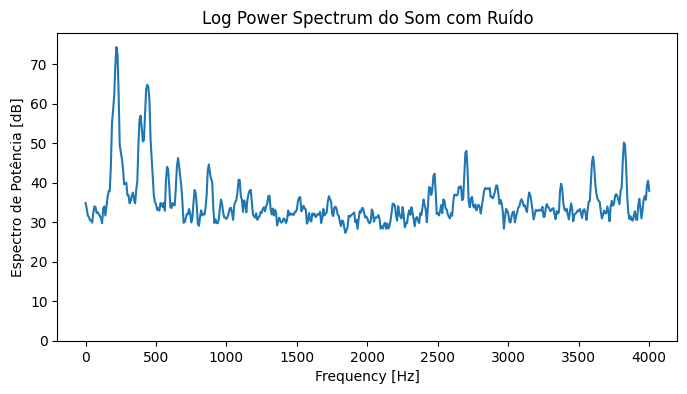

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch

def add_white_gaussian_noise(signal, snr):
    # Calculate the signal power and convert to dB
    signal_power = np.mean(np.float32(signal)**2.0)
    signal_power_db = 10.0 * np.log10(signal_power)

    # Calculate the noise power required for the specified SNR and convert to linear scale
    noise_power_db = signal_power_db - snr
    noise_power = 10.0**(noise_power_db / 10.0)

    # Generate random noise with the required power and add it to the signal
    noise = np.float32(np.random.normal(0.0, np.sqrt(noise_power), len(signal)))
    noisy_signal = signal + noise

    return noise, noisy_signal

def plot_log_power_spectrum(signal, fs, title):
    """ Plota o Power Spectrum em dB de um sinal. """
    f, Pxx = welch(signal, fs=fs, window='hann', nperseg=1024, scaling='spectrum')
    Pxx_dB = 10 * np.log10(Pxx)  # Conversão de potência para dB
    plt.figure(figsize=(8, 4))
    plt.plot(f, Pxx_dB)  # Usando semilog para melhor visualização
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Espectro de Potência [dB]')
    plt.title(title)
    plt.ylim(0, 78)
    # plt.grid(True)
    plt.show()

# Caminho do arquivo WAV
file_path = '/tf/Dados/26.wav'

# Lendo o arquivo WAV
sampling_rate, data = wavfile.read(file_path)

# Adiciona ruído com SNR de 5 dB
noise, noisy_signal = add_white_gaussian_noise(data, 20)

# Plota o Log Power Spectrum do Som Original
plot_log_power_spectrum(data, sampling_rate, 'Log Power Spectrum do Som Original')

# Plota o Log Power Spectrum do Ruído
plot_log_power_spectrum(noise, sampling_rate, 'Log Power Spectrum do Ruído')

# Plota o Log Power Spectrum do Som com Ruído
plot_log_power_spectrum(noisy_signal, sampling_rate, 'Log Power Spectrum do Som com Ruído')


In [24]:
Audio(data=data, rate=8000)

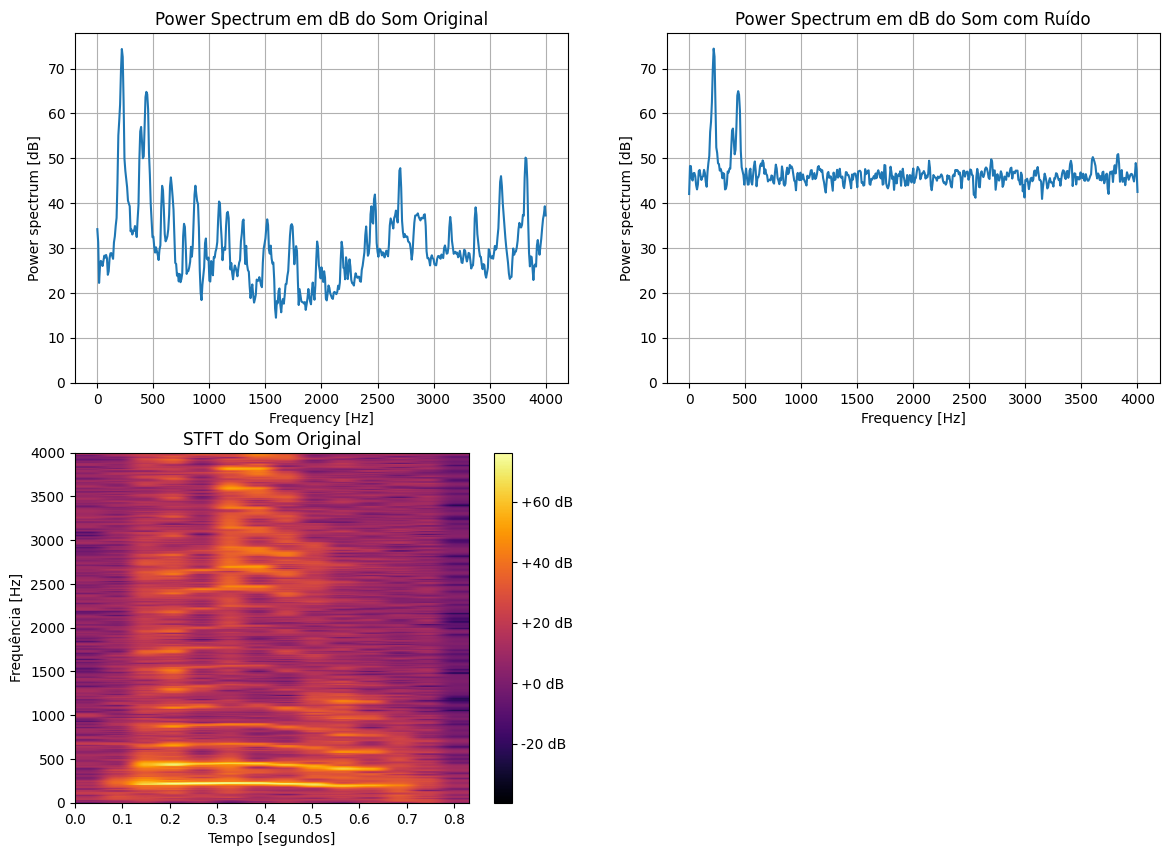

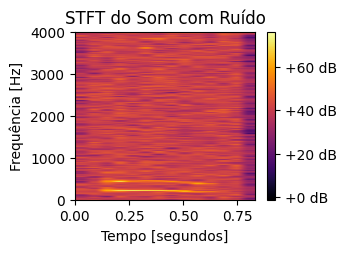

<Figure size 640x480 with 0 Axes>

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch, stft

def add_noise(signal, snr):
    # Calculate the signal power and convert to dB
    signal_power = np.mean(np.float32(signal)**2.0)
    signal_power_db = 10.0 * np.log10(signal_power)

    # Calculate the noise power required for the specified SNR and convert to linear scale
    noise_power_db = signal_power_db - snr
    noise_power = 10.0**(noise_power_db / 10.0)

    # Generate random noise with the required power and add it to the signal
    noise = np.float32(np.random.normal(0.0, np.sqrt(noise_power), len(signal)))
    noisy_signal = signal + noise

    return noise, noisy_signal

def plot_log_power_spectrum(signal, fs, title, subplot_position):
    """Plota o Power Spectrum em dB de um sinal."""
    f, Pxx = welch(signal, fs=fs, window='hann', nperseg=1024, scaling='spectrum')
    Pxx_dB = 10 * np.log10(Pxx)
    plt.subplot(2, 2, subplot_position)
    plt.plot(f, Pxx_dB)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power spectrum [dB]')
    plt.title(title)
    plt.ylim(0, 78)
    plt.grid(True)

def plot_stft(signal, fs, title, subplot_position):
    """Plota a STFT de um sinal."""
    f, t, Zxx = stft(signal, fs=fs, nperseg=1024)
    magnitude_squared_db = 10 * np.log10(np.abs(Zxx)**2)
    plt.subplot(2, 2, subplot_position)
    # Plotar a STFT
    plt.imshow(magnitude_squared_db, aspect='auto', origin='lower', cmap='inferno', extent=[t.min(), t.max(), f.min(), f.max()])
    plt.title(title)
    plt.ylabel('Frequência [Hz]')
    plt.xlabel('Tempo [segundos]')
    plt.colorbar(format='%+2.0f dB')
    plt.ylim(0, fs // 2)
    plt.show()

# Caminho do arquivo WAV
file_path = '/tf/Dados/26.wav'

# Lendo o arquivo WAV
sampling_rate, data = wavfile.read(file_path)

# Adiciona ruído com SNR de 5 dB
noise, noisy_signal = add_noise(data, 5)

plt.figure(figsize=(14, 10))

# Plota o Power Spectrum em dB do Som Original
plot_log_power_spectrum(data, sampling_rate, 'Power Spectrum em dB do Som Original', 1)

# Plota o Power Spectrum em dB do Som com Ruído
plot_log_power_spectrum(noisy_signal, sampling_rate, 'Power Spectrum em dB do Som com Ruído', 2)

# Plota a STFT do Som Original
plot_stft(data, sampling_rate, 'STFT do Som Original', 3)

# Plota a STFT do Som com Ruído
plot_stft(noisy_signal, sampling_rate, 'STFT do Som com Ruído', 4)

plt.tight_layout()
plt.show()